In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import json
from hephaestus.data.ndpwrapper_v2 import Slide_ndpread
import albumentations as A

In [16]:
from Module.config import get_cfg_defaults
cfg = get_cfg_defaults()

In [17]:
cfg

CfgNode({'SYSTEM': CfgNode({'DEVICES': [0], 'USE_HOROVOD': False}), 'DATASET': CfgNode({'SLIDE_DIR': '/mnt/cephrbd/data/A19001_NCKU_SKIN/Image/20191106/', 'JSON_PATH': '/workspace/skin/label/label.json', 'TRAIN_SLIDE': ['2019-10-30 02.03.40.ndpi', '2019-10-30 02.04.50.ndpi', '2019-10-30 02.09.05.ndpi', '2019-10-30 02.07.27.ndpi', '2019-10-30 02.10.47.ndpi', '2019-10-30 02.14.37.ndpi', '2019-10-30 02.18.03.ndpi', '2019-10-30 02.19.24.ndpi', '2019-10-30 02.15.32.ndpi', '2019-10-30 02.23.07.ndpi', '2019-10-30 01.59.42.ndpi', '350013D01170 - 2019-10-30 02.21.40.ndpi'], 'VALID_SLIDE': ['2019-10-30 02.01.19.ndpi', '2019-10-30 02.02.21.ndpi', '2019-10-30 02.05.46.ndpi'], 'EXTENSION': '.ndpi', 'BLUR': 0.1, 'INPUT_SHAPE': (512, 512, 3), 'NUM_WORKER': 10, 'AUGMENT': True, 'PREPROC': False, 'CLASS_MAP': [(225, 0), (56, 1), (43, 2), (53, 3), (45, 4), (42, 5), (54, 6), (41, 7), (202, 8), (55, 9)], 'HIST_NAME': ['background', 'inflammatory infiltration', 'adipose tissue', 'sweat gland', 'hair follic

In [20]:
def is_valid_square(segment):
    if len(segment) != 4:
        return False
    if isinstance(segment, list):
        segment = np.array(segment)
    assert isinstance(segment, np.ndarray)
    xmin = np.min(segment[:, 0])
    ymin = np.min(segment[:, 1])
    xmax = np.max(segment[:, 0])
    ymax = np.max(segment[:, 1])
    if xmin == xmax or ymin == ymax:
        return False
    
    index = -1
    for i in range(4):
        x, y = segment[index]
        if x == xmin and y == ymin:
            index = i
            break
    if index == -1:
        return False
    opposite = (index+2)%4
    if x!= xmax or y != ymax:
        return False
    pos_A = (index+1)%4
    pos_B = (index+3)*4
    ax, ay = segment[pos_A]
    bx, by = segment[pos_B]
    return ((ax == xmin and bx == xmax) or (ax == xmax and bx == xmin)) and (
            (ay == ymin and by == ymax) or (ay == ymax and by == ymin))
    
def get_contours(name, label_file):
    with open(label_file) as f:
        js = json.load(f)
    return None

def get_large_box(x, y, sz):
    '''x, y: center of the large box
       sz: the size of the large box
    '''
    origin = (x-sz//2, y-sz//2)
    

Width: 165120 , Height: 27648


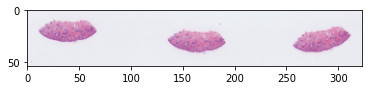

In [21]:
IMG_DIR    = cfg.DATASET.SLIDE_DIR
TEST_IMG   = cfg.DATASET.TRAIN_SLIDE[0]
PATCH_SIZE = cfg.DATASET.INPUT_SHAPE[:2]
THUMB_SIZE = (4096, 4096)

test_slide = Slide_ndpread(IMG_DIR+TEST_IMG)
W, H = test_slide.get_size()
w_stride   = W//PATCH_SIZE[1] if W%(PATCH_SIZE[1]) == 0 else W//PATCH_SIZE[1] + 1
h_stride   = H//PATCH_SIZE[0] if H%(PATCH_SIZE[0]) == 0 else H//PATCH_SIZE[0] + 1
thumbnail  = test_slide.get_patch_with_resize((0, 0), 
                                              src_sz=(w_stride*PATCH_SIZE[1], h_stride*PATCH_SIZE[0]), 
                                              dst_sz=(w_stride, h_stride))
plt.imshow(thumbnail)
plt.show()

In [23]:
class contour2mask:
    def __init__(self, contour):
        '''
        Arg: contour: [[x, y]...]
        '''
        self.contour = np.array(contour)
        self.getbbox()
        self.visit_mask = np.zeros((self.h, self.w))
        self.dirs = [(-1, 0), (1, 0), (0, 1), (0, -1)]
        
        self.draw_contour()
        self.idfs()
        
    def getbbox(self):
        self.xmin = np.min(self.contour[:, 0])
        self.ymin = np.min(self.contour[:, 1])
        self.contour[:, 0] -= self.xmin + 1
        self.contour[:, 1] -= self.ymin + 1
        self.w = np.max(self.contour[:, 0]) +1
        self.h = np.max(self.contour[:, 1]) +1
        
    def draw_contour(self):
        for i in range(self.contour.shape[0]):
            x, y = self.contour[i]
            self.visit_mask[y+1, x+1] = 1
        
    def check_valid(self, x, y):
        return x >= 0 and y >= 0 and x < self.w and y < self.h
        
    def idfs(self):
        '''iterative dfs'''
        x = y = 0
        self.visit_mask[x, y] = 1
        stack = [(x, y)]
        while(len(stack)):
            x, y = stack.pop()
            for dx, dy in self.dirs:
                x = x+dx
                y = y+dy
                if self.check_valid(x, y) and self.visit_mask[y, x] == 0:
                    stack.append((x, y))
                    self.visit_mask[y, x] = 1
        return self.visit_mask[1:-1, 1:-1]            

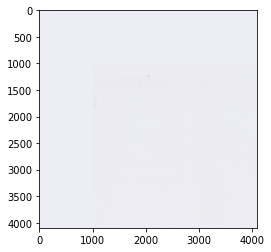

In [24]:
x, y = 1024, 1024
patch = test_slide.get_patch_at_level((x-THUMB_SIZE[0]//2, y-THUMB_SIZE[1]//2), THUMB_SIZE)
#patch = test_slide.get_patch_with_resize((x-THUMB_SIZE[0]//2, y-THUMB_SIZE[1]//2), src_sz=THUMB_SIZE, dst_sz=(1024, 1024))
plt.imshow(patch)

In [49]:
Transform = A.Compose([A.imgaug.transforms.IAASuperpixels(p_replace=1, n_segments=100, always_apply=False, p=1)])
light = A.Compose([
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),    
    A.CLAHE(p=1),    
], p=1)

In [50]:
def augment_and_show(aug, image, mask=None, bboxes=[], categories=[], category_id_to_name=[], filename=None, 
                     font_scale_orig=0.35, font_scale_aug=0.35, show_title=True, **kwargs):

    augmented = aug(image=image, mask=mask, bboxes=bboxes, category_id=categories)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        visualize_bbox(image, bbox, **kwargs)

    for bbox in augmented['bboxes']:
        visualize_bbox(image_aug, bbox, **kwargs)

    if show_title:
        for bbox,cat_id in zip(bboxes, categories):
            visualize_titles(image, bbox, category_id_to_name[cat_id], font_scale=font_scale_orig, **kwargs)
        for bbox,cat_id in zip(augmented['bboxes'], augmented['category_id']):
            visualize_titles(image_aug, bbox, category_id_to_name[cat_id], font_scale=font_scale_aug, **kwargs)

    
    if mask is None:
        f, ax = plt.subplots(1, 2, figsize=(16, 8))
        
        ax[0].imshow(image)
        ax[0].set_title('Original image')
        
        ax[1].imshow(image_aug)
        ax[1].set_title('Augmented image')
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 16))
        
        if len(mask.shape) != 3:
            mask = label2rgb(mask, bg_label=0)            
            mask_aug = label2rgb(augmented['mask'], bg_label=0)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask_aug = cv2.cvtColor(augmented['mask'], cv2.COLOR_BGR2RGB)
            
        ax[0, 0].imshow(image)
        ax[0, 0].set_title('Original image')

        ax[0, 1].imshow(image_aug)
        ax[0, 1].set_title('Augmented image')

        ax[1, 0].imshow(mask, interpolation='nearest')
        ax[1, 0].set_title('Original mask')

        ax[1, 1].imshow(mask_aug, interpolation='nearest')
        ax[1, 1].set_title('Augmented mask')

    f.tight_layout()

    if filename is not None:
        f.savefig(filename)
        
    return augmented['image'], augmented['mask'], augmented['bboxes']

(array([[[185, 116, 172],
         [185, 116, 172],
         [185, 116, 172],
         ...,
         [213, 129, 177],
         [213, 129, 177],
         [213, 129, 177]],
 
        [[185, 116, 172],
         [185, 116, 172],
         [185, 116, 172],
         ...,
         [213, 129, 177],
         [213, 129, 177],
         [213, 129, 177]],
 
        [[185, 116, 172],
         [185, 116, 172],
         [185, 116, 172],
         ...,
         [213, 129, 177],
         [213, 129, 177],
         [213, 129, 177]],
 
        ...,
 
        [[191, 120, 176],
         [191, 120, 176],
         [191, 120, 176],
         ...,
         [206, 116, 169],
         [206, 116, 169],
         [206, 116, 169]],
 
        [[191, 120, 176],
         [191, 120, 176],
         [191, 120, 176],
         ...,
         [206, 116, 169],
         [206, 116, 169],
         [206, 116, 169]],
 
        [[191, 120, 176],
         [191, 120, 176],
         [191, 120, 176],
         ...,
         [206, 116, 169],
  

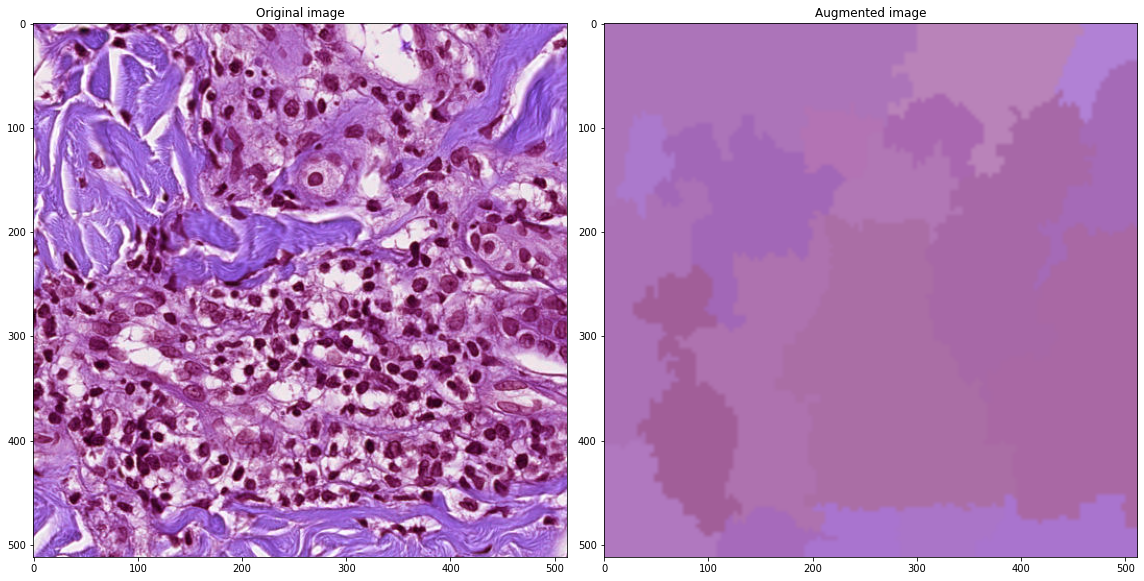

In [52]:
test_patch = test_slide.get_patch_with_resize((50*512, 20*512), src_sz=(512*2, 512*2), dst_sz=(512, 512))
augment_and_show(Transform, test_patch)